In [2]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

from src.CP_VQA.Qulacs_CP_VQA import Qulacs_CP_VQA

from src.Qubo import Qubo
from src.Chain import Chain
from src.Tools import (portfolio_metrics, 
                       min_cost_partition, 
                       get_qubo, 
                       check_qubo)
from src.custom_optimizers.Simulated_annealing import simulated_annealing
from src.custom_optimizers.BFGS import BFGS

In [15]:
def simulate(settings: dict):
    result = {'N':settings['N']}
    # Generating random problem instance 
    expected_returns, covariances = portfolio_metrics(n=settings['N'], seed=settings['seed'])
    # Retrieving C_min, C_max and corresponding states for original portfolio problem
    constrained_result, full_result, lmbda = min_cost_partition(nr_qubits=settings['N'],
                                                                k=settings['k'],
                                                                mu=expected_returns,
                                                                sigma=covariances,
                                                                alpha=settings['alpha'])

    # Generating QUBO corresponding to current problem instance
    Q, offset = get_qubo(mu=expected_returns,
                         sigma=covariances, 
                         alpha=settings['alpha'],
                         lmbda=lmbda+1, # Adding small constant purposely
                         k=settings['k'])
    qubo = Qubo(Q=Q, offset=offset) 
    qubo.subspace_c_min, qubo.subspace_c_max = constrained_result['c_min'], constrained_result['c_max']
    qubo.subspace_x_min, qubo.subspace_x_max = constrained_result['s_min'], constrained_result['s_max']
    qubo.full_space_c_min, qubo.full_space_c_max = full_result['c_min'], full_result['c_max']
    check_qubo(QUBO_matrix=Q, QUBO_offset=offset, expected_returns=expected_returns, covariances=covariances, alpha=settings['alpha'], k=settings['k'])
     

    
    powell = Qulacs_CP_VQA(N_qubits=settings['N'],
                       cardinality=settings['k'],
                       layers=settings['L'],
                       topology=settings['topology'],
                       with_next_nearest_neighbors=settings['w_nnn'],
                       get_full_state_vector=False,
                       qubo=qubo)
     
    cobyla = Qulacs_CP_VQA(N_qubits=settings['N'],
                           cardinality=settings['k'],
                           layers=settings['L'],
                           topology=settings['topology'],
                           with_next_nearest_neighbors=settings['w_nnn'],
                           get_full_state_vector=False,
                           qubo=qubo)
    
    annealing = Qulacs_CP_VQA(N_qubits=settings['N'],
                           cardinality=settings['k'],
                           layers=settings['L'],
                           topology=settings['topology'],
                           with_next_nearest_neighbors=settings['w_nnn'],
                           get_full_state_vector=False,
                           qubo=qubo)

    bfgs = Qulacs_CP_VQA(N_qubits=settings['N'],
                         cardinality=settings['k'],
                         layers=settings['L'],
                         topology=settings['topology'],
                         with_next_nearest_neighbors=settings['w_nnn'],
                         get_full_state_vector=False,
                         qubo=qubo)
    
     # Generating initial guess for rotation angles
    np.random.seed(settings['seed'])
    theta_min, theta_max = -2*np.pi, 2*np.pi
    N_angles = settings['L'] * len(settings['topology'].get_NNN_indices()) if settings['w_nnn'] else settings['L'] * len(settings['topology'].get_NN_indices())
    CPVQA_theta_i = np.random.uniform(theta_min, theta_max, N_angles)
    
    powell_sim_res = sc.optimize.minimize(fun=powell.get_cost, 
                                          x0=CPVQA_theta_i,
                                          method='Powell',
                                          bounds=[(-2*np.pi, 2*np.pi) for _ in range(N_angles)],
                                          options={'disp': False, 
                                                 'maxiter': settings['max_iter'],
                                                   'maxfev': settings['max_iter']},
                                          callback=powell.callback)
    if len(powell.normalized_costs) == 0:
        powell.get_cost(angles=powell_sim_res.x)
        powell.callback()
    powell_norm_c = np.min(powell.normalized_costs)
    powell_p = np.max(powell.opt_state_probabilities)    
    
    cobyla_sim_res = sc.optimize.minimize(fun=cobyla.get_cost, 
                                          x0=CPVQA_theta_i,
                                          method='COBYLA',
                                          bounds=[(-2*np.pi, 2*np.pi) for _ in range(N_angles)],
                                          options={'disp': False, 
                                                   'maxiter': settings['max_iter']},
                                          callback=cobyla.callback)
    cobyla_norm_c = np.min(cobyla.normalized_costs)
    cobyla_p = np.max(cobyla.opt_state_probabilities)
    
    annealing_sim_res = simulated_annealing(fun=annealing.get_cost,
                                            x0=CPVQA_theta_i,
                                            cooling_rate=0.85,
                                            bounds=[(-2*np.pi, 2*np.pi) for _ in range(N_angles)],
                                            initial_temperature=qubo.subspace_c_max,
                                            callback=annealing.callback,
                                            max_iterations=settings['max_iter'])
    annealing_norm_c = np.min(annealing.normalized_costs)
    annealing_p = np.max(annealing.opt_state_probabilities)
    
    """bfgs_sim_res = BFGS(fun=bfgs.get_cost,
                        x0=CPVQA_theta_i,
                        callback=bfgs.callback,
                        max_iterations=settings['max_iter'])
    bfgs_norm_c = np.min(bfgs.normalized_costs)
    bfgs_p = np.max(bfgs.opt_state_probabilities)"""
    
    
    return  {'N':settings['N'], 
             'powell': {'c':powell_norm_c,'p':powell_p, 'res': powell_sim_res}, 
             'cobyla': {'c':cobyla_norm_c,'p':cobyla_p, 'res': cobyla_sim_res},
             'annealing': {'c':annealing_norm_c,'p':annealing_p, 'res': annealing_sim_res}}#,
             #'bfgs': {'c':bfgs_norm_c,'p':bfgs_p, 'res': bfgs_sim_res}}

In [16]:
layer_dict = {2:1,  3:1,  4:2,
              5:2,  6:3,  7:3,
              8:5,  9:6,  10:6,
              11:5, 12:5, 13:5,
              14:5, 15:5, 16:5,
              17:6, 18:6, 19:6, 
              20:7, 21:7, 22:7}

max_iter = 1500
alpha=0.5
N_seeds = 40
N_min, N_max = 4, 10
sim_settings = []
for seed in range(N_seeds):
    for N in range(N_min, N_max+1):
        topology = Chain(N_qubits=N)
        topology.set_initialization_strategy(strategy=np.array([0 if i%2 == 0 else 1 for i in range(N)]))
        setting = {'N'         :N,       'alpha'   :alpha,   'L'       :layer_dict[N], 
                   'seed'      :seed,    'topology':topology,'max_iter':max_iter,
                   'opt_method':'COBYLA','w_nnn'   :True,    'k'       :N//2}
        sim_settings.append(setting)

In [17]:
N_jobs=15
r = Parallel(n_jobs=N_jobs, verbose=51, backend='loky')(delayed(simulate)(setting) for setting in sim_settings)

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   1 tasks      | elapsed:    4.6s
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    4.7s
[Parallel(n_jobs=15)]: Done   3 tasks      | elapsed:    4.9s
[Parallel(n_jobs=15)]: Done   4 tasks      | elapsed:    5.2s
[Parallel(n_jobs=15)]: Done   5 tasks      | elapsed:    5.4s
[Parallel(n_jobs=15)]: Done   6 tasks      | elapsed:    5.5s
[Parallel(n_jobs=15)]: Done   7 tasks      | elapsed:    6.3s
[Parallel(n_jobs=15)]: Done   8 tasks      | elapsed:    6.6s
[Parallel(n_jobs=15)]: Done   9 tasks      | elapsed:    6.8s
[Parallel(n_jobs=15)]: Done  10 tasks      | elapsed:    7.4s
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:    7.4s
[Parallel(n_jobs=15)]: Done  12 tasks      | elapsed:    7.5s
[Parallel(n_jobs=15)]: Done  13 tasks      | elapsed:    8.0s
[Parallel(n_jobs=15)]: Done  14 tasks      | elapsed:    8.4s
[Parallel(n_jobs=15)]: Done  15 tasks      | elapsed:  

In [18]:

cobyla_res  = {N: [] for N in range(N_min,N_max+1)}
powell_res  = {N: [] for N in range(N_min,N_max+1)}
annealing_res  = {N: [] for N in range(N_min,N_max+1)}

for res in r: 
    powell_res[res['N']].append([res['powell']['c'],res['powell']['p'], res['powell']['res'].nfev])
    cobyla_res[res['N']].append([res['cobyla']['c'],res['cobyla']['p'], res['cobyla']['res'].nfev])
    annealing_res[res['N']].append([res['annealing']['c'],res['annealing']['p'], res['annealing']['res'].nfev])


Text(0, 0.5, 'Nfev')

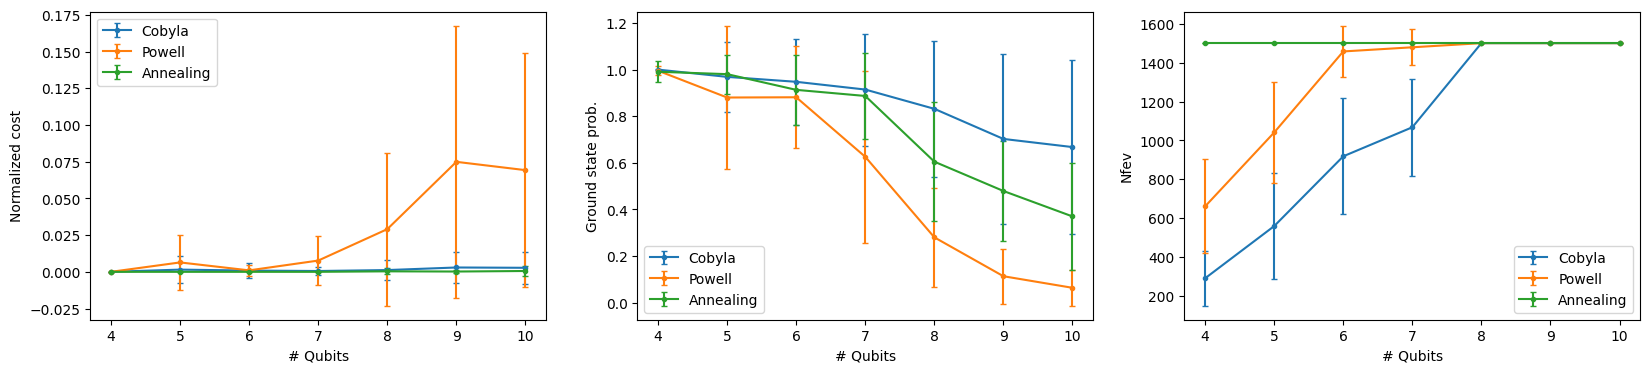

In [19]:

N_vals = [n for n in range(N_min, N_max+1)]

fig, ax = plt.subplots(1,3,figsize=(20,4))


ax[0].errorbar(x=N_vals, 
               y=[np.mean(np.array(cobyla_res[N])[:,0]) for N in range(N_min,N_max+1)], 
               yerr=[np.std(np.array(cobyla_res[N])[:,0]) for N in range(N_min,N_max+1)], 
               fmt='.-', capsize=2, label='Cobyla')
ax[0].errorbar(x=N_vals, 
               y=[np.mean(np.array(powell_res[N])[:,0]) for N in range(N_min,N_max+1)], 
               yerr=[np.std(np.array(powell_res[N])[:,0]) for N in range(N_min,N_max+1)], 
               fmt='.-', capsize=2, label='Powell')
ax[0].errorbar(x=N_vals, 
               y=[np.mean(np.array(annealing_res[N])[:,0]) for N in range(N_min,N_max+1)], 
               yerr=[np.std(np.array(annealing_res[N])[:,0]) for N in range(N_min,N_max+1)], 
               fmt='.-', capsize=2, label='Annealing')

ax[1].errorbar(x=N_vals, 
               y=[np.mean(np.array(cobyla_res[N])[:,1]) for N in range(N_min,N_max+1)], 
               yerr=[np.std(np.array(cobyla_res[N])[:,1]) for N in range(N_min,N_max+1)], 
               fmt='.-', capsize=2, label='Cobyla')

ax[1].errorbar(x=N_vals, 
               y=[np.mean(np.array(powell_res[N])[:,1]) for N in range(N_min,N_max+1)], 
               yerr=[np.std(np.array(powell_res[N])[:,1]) for N in range(N_min,N_max+1)], 
               fmt='.-', capsize=2, label='Powell')
ax[1].errorbar(x=N_vals, 
               y=[np.mean(np.array(annealing_res[N])[:,1]) for N in range(N_min,N_max+1)], 
               yerr=[np.std(np.array(annealing_res[N])[:,1]) for N in range(N_min,N_max+1)], 
               fmt='.-', capsize=2, label='Annealing')

ax[2].errorbar(x=N_vals, 
               y=[np.mean(np.array(cobyla_res[N])[:,2]) for N in range(N_min,N_max+1)], 
               yerr=[np.std(np.array(cobyla_res[N])[:,2]) for N in range(N_min,N_max+1)], 
               fmt='.-', capsize=2, label='Cobyla')

ax[2].errorbar(x=N_vals, 
               y=[np.mean(np.array(powell_res[N])[:,2]) for N in range(N_min,N_max+1)], 
               yerr=[np.std(np.array(powell_res[N])[:,2]) for N in range(N_min,N_max+1)], 
               fmt='.-', capsize=2, label='Powell')
ax[2].errorbar(x=N_vals, 
               y=[np.mean(np.array(annealing_res[N])[:,2]) for N in range(N_min,N_max+1)], 
               yerr=[np.std(np.array(annealing_res[N])[:,2]) for N in range(N_min,N_max+1)], 
               fmt='.-', capsize=2, label='Annealing')

for ax_idx in range(3):
    ax[ax_idx].set_xlabel('# Qubits')
    ax[ax_idx].set_xticks(N_vals)
    ax[ax_idx].legend()

ax[0].set_ylabel('Normalized cost')
ax[1].set_ylabel('Ground state prob.')
ax[2].set_ylabel('Nfev')

#plt.savefig('simulator_comparison_3.png', dpi=400)

In [20]:
a = '001110'
a.count('1')

3